In [5]:
import json
import re
from pathlib import Path
import os,sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sys.path.append(os.path.abspath("../.."))
from utils import apply_nature_axis_style

sns.set(style="whitegrid", context="paper", font_scale=1.5)

# -----------------------------------------------------------
# Strong, well-separated greens + blue for scratch
# -----------------------------------------------------------
greens = sns.color_palette("Greens", 12)
blues  = sns.color_palette("Blues", 12)

MODEL_COLORS = {
    "SSL":              greens[3],   # light green
    "Cls+Gen":          greens[9],   # mid green
#    "Cls+Assign+Gen":   greens[9],   # dark green
    "Scratch":          blues[8],    # strong blue
}

# Marker per dataset size
DATASET_MARKERS = {
    0.03: "o",
    0.10: "s",
#    0.30: "D",
    1.00: "^",
}

# Optional line styles per dataset size (keeps plot readable)
DATASET_LINESTYLES = {
    0.03: ":",
    0.10: "-.",
    0.30: "--",
    1.00: "-",
}

# Head panels
HEAD_PANELS = [
    ("Cls",              False, False),
    ("Cls+Seg",          False, True),
    ("Cls+Assg",         True,  False),
    ("Cls+Seg+Assg",     True,  True),
]

# -----------------------------------------------------------
# Model classifier
# -----------------------------------------------------------
def classify_model(model_name):
    if "pretrain-ablation1" in model_name:
        return "SSL"
    if "pretrain-ablation4" in model_name:
        return "Cls+Gen"
    if "pretrainv1" in model_name:
        return "Cls+Assign+Gen"
    return "Scratch"


# -----------------------------------------------------------
# Effective steps
# -----------------------------------------------------------
N_TOTAL = 1_000_000
BATCH_SIZE = 2048

def effective_steps(epoch, ds_frac):
    return epoch * (ds_frac * N_TOTAL) / (BATCH_SIZE*4)


# -----------------------------------------------------------
# Extract epoch + val-loss from string
# -----------------------------------------------------------
def extract_epoch_val(s):
    if s == "N/A":
        return None, None
    ep = int(s.split("(")[0])
    val = float(s.split("(")[1].rstrip(")"))
    return ep, val


# -----------------------------------------------------------
# MAIN PLOT — 2×2 PANELS + LINES + FULL-WIDTH LEGENDS
# -----------------------------------------------------------
def plot_learning_efficiency_all_heads(models, train_sizes):

    fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=False, sharey=False)
    axes = axes.flatten()

    # -------------------------------------------------------
    # Plot each head panel
    # -------------------------------------------------------
    for i, (head_label, assign_on, seg_on) in enumerate(HEAD_PANELS):

        ax = axes[i]

        for model in models:

            model_type = classify_model(model)
            color = MODEL_COLORS[model_type]

            xs = []
            ys = []
            mks = []
            lss = []
            epochs = []

            for ds in train_sizes:

                ckpt, loss_json = get_epoch_val(model, ds, assign_on, seg_on)
                ep, _ = extract_epoch_val(ckpt)
                with open(loss_json, "r") as f:
                    data_loss = json.load(f)
                if not("30" in data_loss):
                    continue
                val = data_loss["30"]["total_loss"]
                epochs.append(ep)

                if ep is None:
                    continue

                xs.append(effective_steps(ep, ds))
                ys.append(val)
                mks.append(DATASET_MARKERS[ds])
                lss.append(DATASET_LINESTYLES[ds])

            # Plot line first (thin)
            if len(xs) > 1:
                ax.plot(xs, ys, color=color, linewidth=1.6, alpha=0.85)

            for ep, ds, xx, yy, mk in zip(epochs, train_sizes, xs, ys, mks):

                # ---- X uncertainty band (±1 epoch), thin horizontal band ----
                # x_low  = effective_steps(ep - 1, ds)
                # x_high = effective_steps(ep + 1, ds)

                # very thin vertical extent around yy
                dy = 0.003 * yy   # adjust 0.015 → thicker or thinner

                # ax.fill_between(
                #     [x_low, x_high],
                #     [yy - dy, yy - dy],
                #     [yy + dy, yy + dy],
                #     color=color,
                #     alpha=0.8,
                # )

                # --- Point ---
                ax.scatter(
                    xx, yy,
                    s=130,
                    color=color,
                    marker=mk,
                    edgecolor="black",
                    linewidth=0.7,
                    alpha=0.95,
                )


        ax.set_title(head_label, fontsize=18, weight="bold")
        ax.set_xscale("log")
        ax.grid(True, linestyle="--", alpha=0.55)
        ax.set_xlabel("Effective steps", fontsize=16)
        ax.set_ylabel("Val loss", fontsize=16)
        apply_nature_axis_style(ax)

    # -------------------------------------------------------
    # FULL-WIDTH SPLIT LEGEND (MODEL + DATASET SIZE)
    # -------------------------------------------------------

    # -------------------------------------
    # Legend 1 — model types (colors)
    # -------------------------------------
    model_handles = [
        plt.Line2D([0], [0],
                   marker="s", color=c, markersize=14, linewidth=0,
                   markeredgecolor="black", label=label)
        for label, c in MODEL_COLORS.items()
    ]

    # -------------------------------------
    # Legend 2 — dataset sizes (markers)
    # -------------------------------------
    ds_handles = [
        plt.Line2D([0], [0],
                   marker=mk, color="gray", markersize=14, linewidth=0,
                   markeredgecolor="black", label=f"{int(ds*100)}%")
        for ds, mk in DATASET_MARKERS.items()
    ]

    # ---- MODEL TYPES LEGEND (bold, left aligned, same row) ----
    title_model = plt.Line2D([], [], linestyle="none",
                             label=r"$\bf{Model\ Types.}$")

    model_handles_row = [title_model] + model_handles
    model_labels_row  = [r"$\bf{Model\ Types.}$"] + \
                        [h.get_label() for h in model_handles]

    fig.legend(
        handles=model_handles_row,
        labels=model_labels_row,
        loc="upper center",
        bbox_to_anchor=(0.5, 1.06),   # move slightly above panel
        ncol=len(model_handles_row),
        frameon=False,
        fontsize=16,
    )

    # ---- DATASET SIZE LEGEND (bold, left aligned, same row) ----
    title_ds = plt.Line2D([], [], linestyle="none",
                          label=r"$\bf{Dataset\ Sizes.}$")

    ds_handles_row = [title_ds] + ds_handles
    ds_labels_row  = [r"$\bf{Dataset\ Sizes.}$"] + \
                     [h.get_label() for h in ds_handles]

    fig.legend(
        handles=ds_handles_row,
        labels=ds_labels_row,
        loc="upper center",
        bbox_to_anchor=(0.5, 1.015),   # slightly below model legend
        ncol=len(ds_handles_row),
        frameon=False,
        fontsize=16,
    )


    plt.tight_layout(rect=[0, 0, 1, 0.95])
    fig.savefig("plots/loss.pdf",bbox_inches="tight")

    plt.show()

def get_epoch_val(model, size, assign_on, seg_on):
    d = run_dir(model, assign_on, seg_on, size)
    summary_path = os.path.join(ROOT_predictions,
        f"{model}"
        f"-assignment-{'on' if assign_on else 'off'}"
        f"-segmentation-{'on' if seg_on else 'off'}"
        f"-dataset_size{size}",
        "loss.json"
    ).replace("ma30-","").replace("ma40-", "").replace("ma60-","")
    return best_checkpoint(d), summary_path


In [6]:
HEAD_ORDER_DEFAULT = ["Cls", "Cls+Seg", "Cls+Assign", "Cls+Assign+Seg"]

HEAD_LINESTYLES = {
    "Cls": "-",
    "Cls+Seg": "-.",
    "Cls+Assign": "--",
    "Cls+Assign+Seg": ":",
}

MODEL_COLORS = {
    "SPANet": "#7f7f7f",                     # gray
    "EveNet-Scratch": blues[8],             # blue
    "EveNet-f.t.(SSL)": greens[3],           # green
    "EveNet-f.t.(Cls+Gen)": greens[6],       # darker green
    "EveNet-f.t.(Cls+Assign+Gen)": greens[9] # darkest green
}
MODEL_ORDER_FIXED = [
    "SPANet",
    "EveNet-Scratch",
    "EveNet-f.t.(SSL)",
    "EveNet-f.t.(Cls+Gen)",
    "EveNet-f.t.(Cls+Assign+Gen)",
]


In [10]:
import os
import re
import json
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
import seaborn as sns
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

sns.set(style="whitegrid", context="paper", font_scale=1.2)

# -----------------
# Parsing utilities
# -----------------
def convert_to_SIC(sig_eff, bkg_rej, bkg_rej_unc=None):
    """
    Convert background rejection to SIC:
        SIC = sig_eff * sqrt(bkg_rej)
    and propagate uncertainty:
        dSIC = sig_eff * (1/(2 sqrt(bkg_rej))) * d(bkg_rej)
    """
    if bkg_rej <= 0:
        return None, None

    import math
    sic = sig_eff * math.sqrt(bkg_rej)

    if bkg_rej_unc is None:
        return sic, None

    sic_unc = sig_eff * (0.5 / math.sqrt(bkg_rej)) * bkg_rej_unc
    return sic, sic_unc

def parse_legend(legend):
    """
    Extract base legend and dataset size from legend string.

    Example:
        'spanet-something-dataset_size0.1' -> ("spanet-something", "0.1")
    """
    match = re.match(r"(.+)-dataset_size([0-9]*\.?[0-9]+)", legend)
    if match:
        base_legend = match.group(1)
        dataset_size = str(match.group(2))
        return base_legend, dataset_size
    else:
        return legend, None

def extract_sig_eff_from_metric_name(metric_key):
    # expects "..._at_XXpct_signal"
    m = re.search(r"at_(\d+)pct_signal", metric_key)
    return int(m.group(1)) / 100.0 if m else None

def convert_metrics_key(key, mass):
    """
    Convert metric key by replacing MASS and WORD placeholders (for Purity json).
    """
    word_dict = {30: "thirty", 40: "forty", 60: "sixty"}
    return key.replace("MASS", str(mass)).replace("WORD", word_dict.get(int(mass), mass))

def extract_metric(sr_data, key):
    """
    For nested dict keys like "BackgroundRejection.bkg_rejection_at_70pct_signal".
    """
    parts = key.split(".")
    for part in parts:
        sr_data = sr_data[part]
    return sr_data

# -------------------------
# Model & head classification
# -------------------------
def classify_model_type(base_legend):
    """
    Map a legend string to a model category.
    Uses your existing convention.
    """
    if "spanet" in base_legend:
        return "SPANet"
    if "scratch" in base_legend:
        return "EveNet-Scratch"
    if "pretrain" in base_legend:
        if "ablation1" in base_legend:
            return "EveNet-f.t.(SSL)"
        if "ablation4" in base_legend:
            return "EveNet-f.t.(Cls+Gen)"
        if "pretrainv1" in base_legend:
            return "EveNet-f.t.(Cls+Assign+Gen)"

    # skip (return None so caller can ignore)
    return None


def classify_head_type(base_legend):
    """
    Determine which heads are ON from the legend string.
    """
    assignment_on   = "assignment-on"   in base_legend
    segmentation_on = "segmentation-on" in base_legend

    if assignment_on and segmentation_on:
        return "Cls+Assign+Seg"
    if assignment_on and not segmentation_on:
        return "Cls+Assign"
    if not assignment_on and segmentation_on:
        # you didn't explicitly need this, but let's treat it separately if it appears
        return "Cls+Seg"
    return "Cls"

HEAD_ORDER_DEFAULT = ["Cls", "Cls+Assign", "Cls+Assign+Seg"]

# -------------------------
# Uncertainty key helper
# -------------------------

def get_unc_metric_key(metric_key, mass=None):
    """
    Given a metric key, return the matching uncertainty key (if standard).
    - Purity json: '<metric>-unc'
    - BackgroundRejection: replace 'BackgroundRejection.' with 'BackgroundRejection-unc.'
    """
    if "Purity" in metric_key:
        return metric_key + "-unc"

    if metric_key.startswith("BackgroundRejection."):
        return metric_key.replace("BackgroundRejection.", "BackgroundRejection-unc.", 1)

    # AUC or others: no standard uncertainty
    return None

# -------------------------
# Data loading for combined plot
# -------------------------

def load_metric_data_for_mass(
    metrics_dir,
    mass,
    metric_key,
    training_dataset_size_absolute=1_000_000,
    dataset_size_min_frac=0.0,
    use_sic=False
):
    """
    Scan metrics_dir (each subdir is a legend), read metric for one mass.
    Returns nested dict:
      data[head_type][model_type] -> list of (dataset_size_abs, value, unc or None)
    Purity -> json from metrics_dir/legend/summary.json (assignment_metrics)
    Others -> npz from metrics_dir/legend/summary/roc_results.npz
    """

    mass = str(mass)
    mass_int = int(mass)
    metric_is_purity = "Purity" in metric_key

    data = defaultdict(lambda: defaultdict(list))

    for legend in os.listdir(metrics_dir):
        legend_dir = os.path.join(metrics_dir, legend)
        if not os.path.isdir(legend_dir):
            continue

        base_legend, dataset_size_str = parse_legend(legend)
        if dataset_size_str is None:
            continue

        ds_frac = float(dataset_size_str)
        if ds_frac < dataset_size_min_frac:
            continue

        ds_abs = ds_frac * training_dataset_size_absolute

        # load appropriate file
        if metric_is_purity:
            # assignment_metrics case: summary.json at metrics_dir/legend/summary.json
            summary_json = os.path.join(legend_dir, "summary.json")
            if not os.path.isfile(summary_json):
                continue
            with open(summary_json, "r") as f:
                roc_data = json.load(f)

            key = f"haa_ma{mass}"
            if key not in roc_data:
                continue

            metric_key_resolved = convert_metrics_key(metric_key, mass_int)
            unc_metric_key = get_unc_metric_key(metric_key_resolved, mass_int)

            if metric_key_resolved not in roc_data[key]:
                continue

            value = roc_data[key][metric_key_resolved]
            value_unc = roc_data[key].get(unc_metric_key, None)

        else:
            # roc_results.npz case
            roc_results = os.path.join(legend_dir, "summary", "roc_results.npz")
            if not os.path.isfile(roc_results):
                continue
            roc_npz = np.load(roc_results, allow_pickle=True)

            key = f"haa_ma{mass}"
            if key not in roc_npz:
                continue

            try:
                sr_data = roc_npz[key].item()["SR"]
            except Exception:
                continue

            value = extract_metric(sr_data, metric_key)
            unc_metric_key = get_unc_metric_key(metric_key, mass_int)
            if unc_metric_key is not None:
                try:
                    value_unc = extract_metric(sr_data, unc_metric_key)
                except Exception:
                    value_unc = None
            else:
                value_unc = None

            if use_sic and "BackgroundRejection" in metric_key:
                sig_eff = extract_sig_eff_from_metric_name(metric_key)
                value, value_unc = convert_to_SIC(sig_eff, value, value_unc)
        model_type = classify_model_type(base_legend)
        head_type  = classify_head_type(base_legend)

        data[head_type][model_type].append((ds_abs, value, value_unc))

    # sort each list by dataset size
    for head, models_dict in data.items():
        for model, entries in models_dict.items():
            models_dict[model] = sorted(entries, key=lambda x: x[0])

    return data

# -------------------------
# Plotting: left panel (bars)
# -------------------------

def plot_heads_models_bars(
    ax,
    data,
    head_order=HEAD_ORDER_DEFAULT,
    model_order=None,
    model_colors=None,
    metric_label="Metric",
):
    """
    Left panel: groups = head types, bars = models, with error bars from unc.
    EXACT original behavior except x-axis label.
    """

    # Determine model order
    if model_order is None:
        model_set = set()
        for head in data.values():
            for model in head.keys():
                if model is not None:
                    model_set.add(model)
        model_order = [m for m in MODEL_ORDER_FIXED if m in model_set]


    # Colors (use your chosen MODEL_COLORS)
    if model_colors is None:
        model_colors = MODEL_COLORS

    n_heads = len(head_order)
    n_models = len(model_order)

    indices = np.arange(n_heads)
    total_group_width = 0.8
    bar_width = total_group_width / n_models

    for i_model, model in enumerate(model_order):
        xs = []
        heights = []
        errs = []

        for i_head, head in enumerate(head_order):
            if head not in data or model not in data[head]:
                xs.append(indices[i_head] + (i_model - (n_models-1)/2)*bar_width)
                heights.append(0)
                errs.append(0)
                continue

            entries = data[head][model]
            ds_abs, value, unc = entries[-1]

            xs.append(indices[i_head] + (i_model - (n_models-1)/2)*bar_width)
            heights.append(value)
            errs.append(unc if unc is not None else 0)

        ax.bar(
            xs,
            heights,
            width=bar_width,
            label=model,
            color=model_colors.get(model, "gray"),
            edgecolor="black",
            linewidth=0.8,
            yerr=errs,
            capsize=3,
            alpha=0.9,
        )

    ax.set_xticks(indices)
    ax.set_xticklabels(head_order)
    ax.set_ylabel(metric_label)

    # --- The ONLY modification you originally asked for ---
    ax.set_xlabel("Full Dataset Size")

    ax.grid(True, axis="y", linestyle="--", linewidth=0.5, alpha=0.7)

    return model_order


# -------------------------
# Plotting: right panel (lines vs dataset size)
# -------------------------

def plot_heads_models_lines(
    ax,
    data,
    head_order=HEAD_ORDER_DEFAULT,
    model_order=None,
    model_colors=MODEL_COLORS,
    metric_label="Metric",
):
    if model_order is None:
        model_order = sorted([
            m for head in data.values() for m in head if m in model_colors
        ])

    for model in model_order:
        color = model_colors[model]

        for head in head_order:
            if head not in data or model not in data[head]:
                continue

            entries = data[head][model]
            xs = [e[0] for e in entries]
            ys = [e[1] for e in entries]
            ucs = [e[2] for e in entries]

            ax.plot(
                xs, ys,
                color=color,
                linestyle=HEAD_LINESTYLES[head],
                linewidth=2,
                marker="o",
            )

            # Only Cls gets uncertainty fill
            if head == "Cls" and any(ucs):
                lower = [y - (u or 0) for y, u in zip(ys, ucs)]
                upper = [y + (u or 0) for y, u in zip(ys, ucs)]
                ax.fill_between(xs, lower, upper, color=color, alpha=0.18)

    ax.set_xscale("log")
    ax.set_xlabel("Dataset Size")
    ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
    ax.set_ylabel(metric_label)

# -------------------------
# Combined figure (3:1)
# -------------------------

def plot_heads_models_combined(
    metrics_dir,
    mass,
    metric_key,
    dataset_size_min_frac=0.02,
    training_dataset_size_absolute=1_000_000,
    head_order=HEAD_ORDER_DEFAULT,
    figsize=(14,7),
    panel_ratio=(3,2),# <-- ratio tunable here
    use_sic=False,
    y_min=None,
    plotdir="./",
    fname=None
):
    metric_is_purity = "Purity" in metric_key

    metric_label = metric_key.replace("BackgroundRejection.", "Bkg Rej @ ") \
                             .replace("bkg_rejection_at_", r"$\epsilon_{sig}$ = ") \
                             .replace("pct_signal", "%")
    if use_sic:
        metric_label = metric_label.replace("Bkg Rej", "SIC")

    if metric_is_purity:
        metric_label = "Event Purity"

    data = load_metric_data_for_mass(
        metrics_dir, mass, metric_key,
        training_dataset_size_absolute,
        dataset_size_min_frac,
        use_sic=use_sic
    )
    if not data:
        print("No data found.")
        return

    fig = plt.figure(figsize=figsize)
    gs = GridSpec(1,2,width_ratios=list(panel_ratio))

    ax_left = fig.add_subplot(gs[0])
    ax_right = fig.add_subplot(gs[1], sharey=ax_left)

    # Left panel
    model_order = plot_heads_models_bars(
        ax_left, data, head_order=head_order,
        model_colors=MODEL_COLORS,
        metric_label=metric_label
    )

    # Right panel
    plot_heads_models_lines(
        ax_right, data, head_order=head_order,
        model_order=model_order,
        model_colors=MODEL_COLORS,
        metric_label=metric_label
    )
    ax_right.set_ylabel(None)

    for ax in [ax_left, ax_right]:
        if y_min is not None:
            ax.set_ylim(bottom=y_min)
        # 1. Ticks pointing inward
        ax.tick_params(axis='both', which='both',
                       direction='in',
                       length=6, width=1.3, labelsize=12)

        # 2. Minor ticks
        ax.minorticks_on()
        ax.tick_params(axis='both', which='minor',
                       length=3, width=1.0)
        #
        # # 3. CMS-style spines
        # ax.spines['top'].set_visible(False)
        # ax.spines['right'].set_visible(False)
        # ax.spines['left'].set_linewidth(1.4)
        # ax.spines['bottom'].set_linewidth(1.4)

        # # 4. Y-grid only on major ticks (subtle)
        # ax.grid(False, axis="y", which="major",
        #         linestyle="--", linewidth=0.6, alpha=0.6)
        #
        # # No minor grid
        # ax.grid(False, which="minor")
        # ax.yaxis.set_minor_locator(MultipleLocator(1))

    apply_nature_axis_style(ax_left)
    apply_nature_axis_style(ax_right)



    # ---------------------------------------------------------
    # LEGENDS (two rows, bold left-aligned, no borders)
    # ---------------------------------------------------------

    # Model Types legend
    model_handles = [
        Line2D([0],[0], marker="s", color=MODEL_COLORS[m],
               markeredgecolor="black", markersize=10, linewidth=0,label=m)
        for m in model_order
    ]

    fig.legend(
        handles=[Line2D([],[],linestyle="none",
                        label=r"$\bf{Model\ Types}$")] + model_handles,
        labels=[r"$\bf{Model\ Types}$"] + model_order,
        loc="upper center",
        bbox_to_anchor=(0.5,1.05),
        ncol=len(model_order)+1,
        frameon=False,
        fontsize=13
    )

    # Head Types legend
    head_handles = [
        Line2D([0],[0], color="black", linestyle=HEAD_LINESTYLES[h],
               linewidth=2, label=h)
        for h in head_order
    ]

    fig.legend(
        handles=[Line2D([],[],linestyle="none",
                        label=r"$\bf{Head\ Types}$")] + head_handles,
        labels=[r"$\bf{Head\ Types}$"] + head_order,
        loc="upper center",
        bbox_to_anchor=(0.5,1.01),
        ncol=len(head_order)+1,
        frameon=False,
        fontsize=13
    )

    plt.tight_layout(rect=[0,0,1,0.94])
    if fname is not None:
        os.makedirs(plotdir, exist_ok=True)
        fig.savefig(f"{plotdir}/{fname}",bbox_inches="tight")
    plt.show()

    return fig, ax_left, ax_right




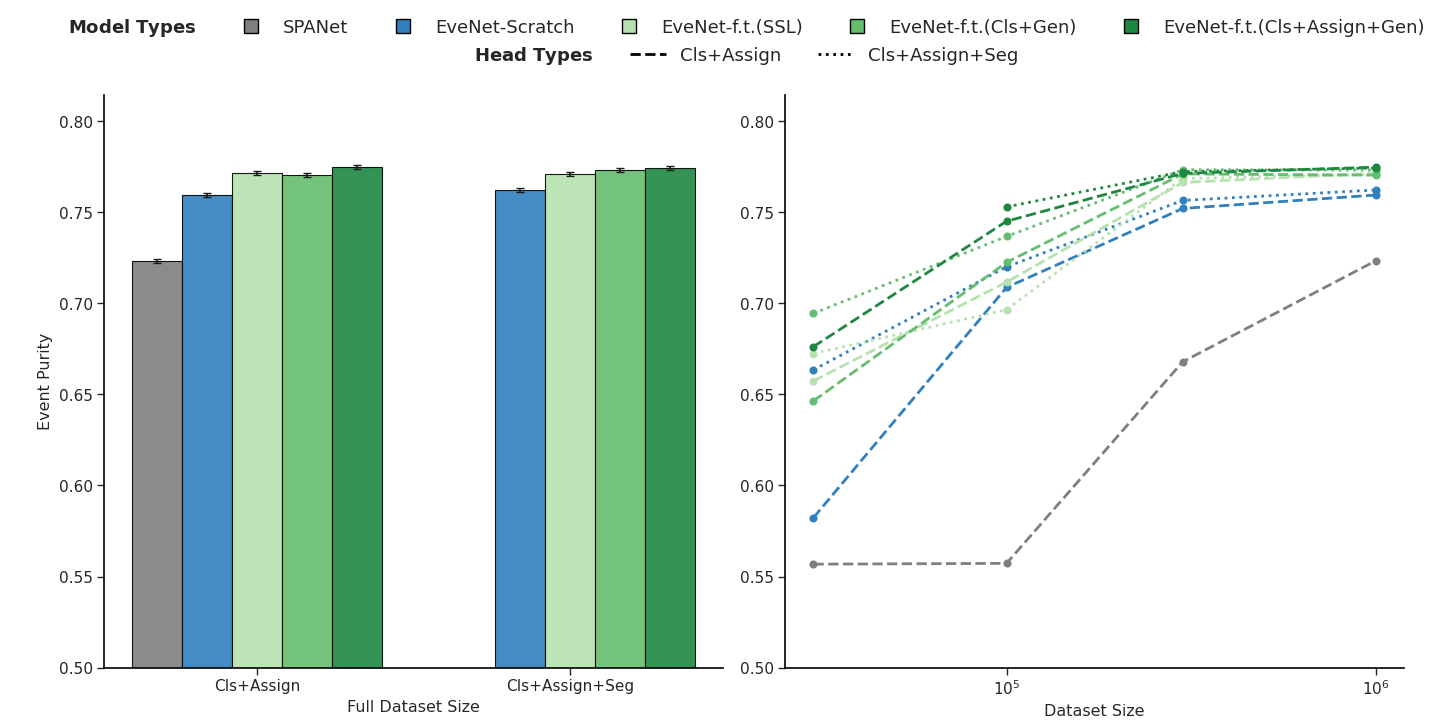

In [11]:
mass = 30  # example
store_dir = "data/BSM"
fit_ass_dir = os.path.join(store_dir, "assignment_metrics")

metric_key_purity = "haa_maMASS/Purity/*a_WORD/event_purity"

BSM_pairing = plot_heads_models_combined(
    metrics_dir=fit_ass_dir,
    mass=mass,
    metric_key=metric_key_purity,
    dataset_size_min_frac=0.02,
    training_dataset_size_absolute=1_000_000,
    head_order=["Cls+Assign", "Cls+Assign+Seg"],
    y_min = 0.5,
    panel_ratio = (2,2),
    plotdir = "plot/BSM",
    fname="pairing.pdf"

)

data/BSM/fit


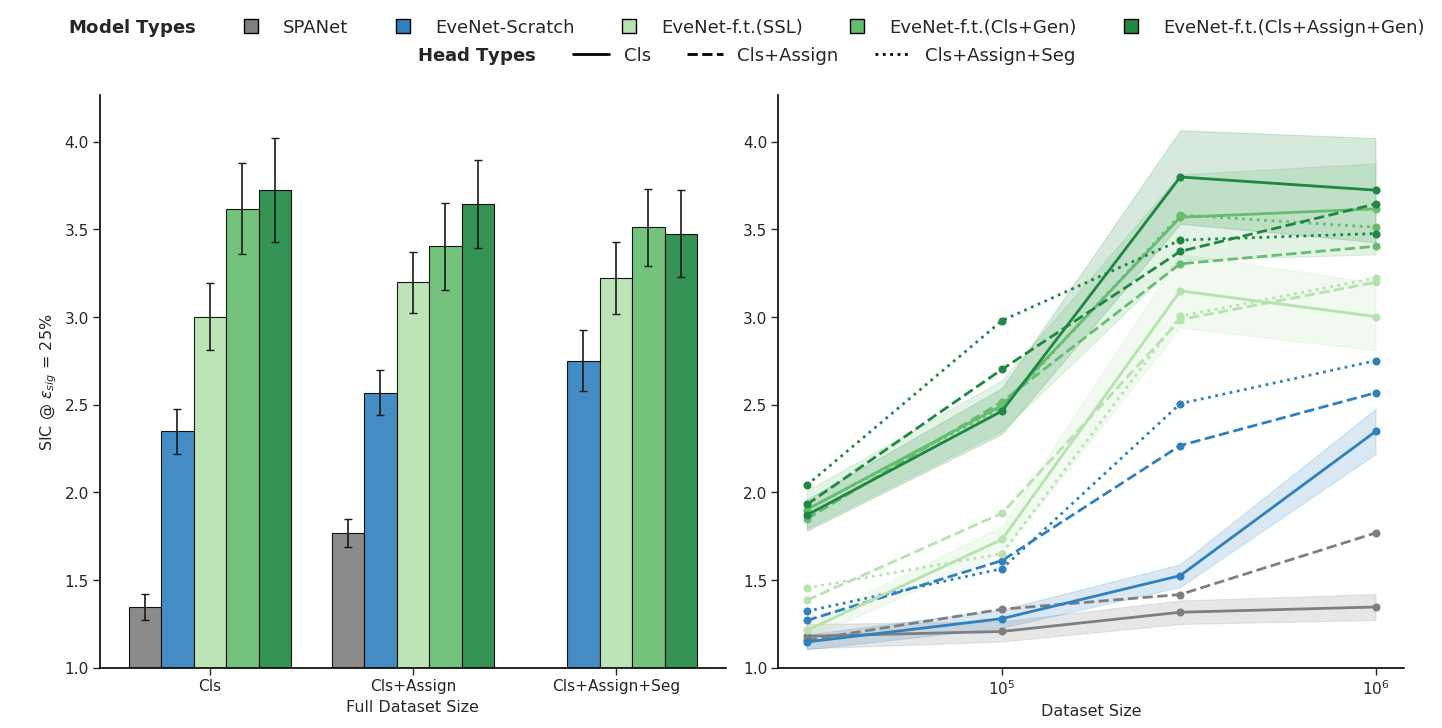

In [12]:
metric_key_purity = metric_key = "BackgroundRejection.bkg_rejection_at_{}pct_signal".format(25)
fit_dir = os.path.join(store_dir, "fit")
print(fit_dir)
BSM_cls = plot_heads_models_combined(
    metrics_dir=fit_dir,
    mass=mass,
    metric_key=metric_key_purity,
    dataset_size_min_frac=0.02,
    training_dataset_size_absolute=1_000_000,
    head_order=["Cls", "Cls+Assign", "Cls+Assign+Seg"],
    panel_ratio = (2,2),
    use_sic=True,
    y_min=1.0,
    plotdir="plot/BSM",
    fname="class.pdf"
)


In [16]:
def extract_full_roc(metrics_dir, legend, mass):
    """
    Expect ROC stored as:
        roc_npz[key].item()["SR"]["TPR"]
        roc_npz[key].item()["SR"]["FPR"]
        roc_npz[key].item()["SR"]["FPR-unc"]

    Returns:
        TPR, FPR, FPR_unc      (all np.array)
    """

    roc_path = os.path.join(metrics_dir, legend, "summary", "roc_results.npz")
    if not os.path.isfile(roc_path):
        return None

    roc_npz = np.load(roc_path, allow_pickle=True)
    key = f"haa_ma{mass}"
    if key not in roc_npz:
        return None

    try:
        sr = roc_npz[key].item()["SR"]
    except Exception:
        return None

    if "TPR" not in sr or "FPR" not in sr:
        return None

    TPR = np.asarray(sr["TPR"])[2:]
    FPR = np.asarray(sr["FPR"])[2:]
    FPR_unc = np.asarray(sr.get("FPR-unc", np.zeros_like(FPR)))[2:]

    return TPR, FPR, FPR_unc
def compute_sic_with_unc(TPR, FPR, FPR_unc):
    FPR = np.clip(FPR, 1e-4, 1)
    SIC = TPR / np.sqrt(FPR)
    SIC_unc = TPR * (0.5 / (np.sqrt(FPR) ** 3)) * FPR_unc
    return SIC, SIC_unc
def is_full_dataset(legend):
    base_legend, ds = parse_legend(legend)
    return (ds == "1.0")
from collections import defaultdict
from matplotlib.gridspec import GridSpec

from scipy.signal import savgol_filter
from collections import defaultdict
from matplotlib.gridspec import GridSpec

def smooth_curve(y, window=31, poly=3):
    """
    Smooth 1D array with Savitzky–Golay filtering.
    Auto-adjust window if the ROC array is short.
    """
    if len(y) < window:
        window = max(5, len(y) // 2 * 2 + 1)
    if window < 5:
        return y
    return savgol_filter(y, window_length=window, polyorder=poly, mode="interp")


def plot_sic_suite_full_dataset(
    metrics_dir,
    mass,
    head_order=HEAD_ORDER_DEFAULT,
    figsize=(12, 6),
    fname=None,
    plotdir="./"
):

    # ============================================================
    # LOAD DATA
    # ============================================================
    results = []

    for legend in os.listdir(metrics_dir):
        base_legend, ds = parse_legend(legend)
        if ds != "1.0":
            continue

        model = classify_model_type(base_legend)
        head  = classify_head_type(base_legend)
        if model is None or head is None:
            continue

        r = extract_full_roc(metrics_dir, legend, mass)
        if r is None:
            continue

        TPR, FPR, FPR_unc = r
        results.append({
            "model": model,
            "head": head,
            "TPR": TPR,
            "FPR": FPR,
            "FPR_unc": FPR_unc,
        })

    if len(results) == 0:
        print("No full-dataset results found.")
        return

    # ============================================================
    # FIGURE with 1:1:1
    # ============================================================
    fig = plt.figure(figsize=figsize)
    gs = GridSpec(1, 2, width_ratios=[1, 1])

    ax_curve   = fig.add_subplot(gs[0])
    ax_bar     = fig.add_subplot(gs[1])
    # ax_scatter = fig.add_subplot(gs[2])

    # ============================================================
    # PANEL (A) — SIC CURVE
    # ============================================================
    for r in results:
        model = r["model"]
        head  = r["head"]
        T = r["TPR"]
        B = r["FPR"]
        Bu = r["FPR_unc"]

        SIC, SIC_unc = compute_sic_with_unc(T, B, Bu)

        # --- smoothing ---
        SIC_s = smooth_curve(SIC)
        SIC_unc_s = smooth_curve(SIC_unc)

        color = MODEL_COLORS.get(model, "gray")
        ls    = HEAD_LINESTYLES.get(head, "-")

        ax_curve.plot(
            T, SIC_s,
            color=color,
            linestyle=ls,
            linewidth=2
        )

        # --- uncertainty ONLY for head = "Cls" ---
        if head == "Cls":
            ax_curve.fill_between(
                T,
                SIC_s - SIC_unc_s,
                SIC_s + SIC_unc_s,
                color=color,
                alpha=0.18
            )

    ax_curve.set_xlabel("Signal efficiency")
    ax_curve.set_ylabel(r"SIC = $\epsilon_{\rm sig} / \sqrt{\epsilon_{\rm bkg}}$")

    ax_curve.grid(True, linestyle="--", alpha=0.5)
    apply_nature_axis_style(ax_curve)

    # ============================================================
    # PANEL (B) — MAX SIC BAR with uncertainty
    # ============================================================
    grouped_val = defaultdict(lambda: defaultdict(float))
    grouped_err = defaultdict(lambda: defaultdict(float))

    for r in results:
        T = r["TPR"]
        B = r["FPR"]
        Bu = r["FPR_unc"]

        SIC, SIC_unc = compute_sic_with_unc(T, B, Bu)
        idx = np.argmax(SIC)

        max_sic     = SIC[idx]
        max_sic_unc = SIC_unc[idx]

        grouped_val[r["head"]][r["model"]] = max_sic
        grouped_err[r["head"]][r["model"]] = max_sic_unc

    model_order = [m for m in MODEL_COLORS.keys()
                   if any(m in d for d in grouped_val.values())]

    n_heads = len(head_order)
    n_models = len(model_order)
    indices = np.arange(n_heads)
    bar_width = 0.75 / max(1, n_models)

    for i_m, model in enumerate(model_order):
        xs, ys, yerr = [], [], []

        for i_h, head in enumerate(head_order):
            val = grouped_val.get(head, {}).get(model, 0)
            err = grouped_err.get(head, {}).get(model, 0)
            xs.append(indices[i_h] + (i_m - (n_models-1)/2)*bar_width)
            ys.append(val)
            yerr.append(err)

        ax_bar.bar(
            xs, ys,
            width=bar_width,
            color=MODEL_COLORS.get(model),
            edgecolor="black",
            alpha=0.9,
            linewidth=0.8,
            yerr=yerr,
            capsize=4,
            label=model
        )

    ax_bar.set_xticks(indices)
    ax_bar.set_xticklabels(head_order)
    ax_bar.set_ylabel("Max SIC")
    ax_bar.grid(True, axis="y", linestyle="--", alpha=0.5)
    apply_nature_axis_style(ax_bar)

    # ============================================================
    # PANEL (C) — MAX SIC vs EFF scatter + head labels
    # ============================================================
    markers = {"Cls": "o", "Cls+Assign": "s", "Cls+Assign+Seg": "D"}

    # for r in results:
    #     T = r["TPR"]
    #     B = r["FPR"]

    #     SIC, _ = compute_sic_with_unc(T, B, np.zeros_like(B))
    #     idx = np.argmax(SIC)

    #     eff_s = T[idx]
    #     max_sic = SIC[idx]

    #     ax_scatter.scatter(
    #         eff_s, max_sic,
    #         color=MODEL_COLORS.get(r["model"]),
    #         marker=markers.get(r["head"], "o"),
    #         s=80,
    #         alpha=0.9
    #     )

    # ax_scatter.set_xlabel("Signal efficiency at max SIC")
    # ax_scatter.set_ylabel("Max SIC")
    # apply_nature_axis_style(ax_scatter)

    # ============================================================
    # SHARED LEGEND — two rows
    # ============================================================
    
    # MARKERS used in scatter (consistent across legend)
    markers = {"Cls": "o", "Cls+Assign": "s", "Cls+Assign+Seg": "D"}
    
    # =====================
    # LEGEND ROW 1 — MODELS
    # =====================
    
    model_header = Line2D([], [], linestyle="none",
                          label=r"$\bf{Model\ Types}$")
    
    model_handles = [
        Line2D([0],[0],
               marker="s",
               color=MODEL_COLORS[m],
               markerfacecolor=MODEL_COLORS[m],
               markersize=11,
               linestyle="none",
               markeredgecolor="black",
               label=m)
        for m in model_order
    ]
    
    legend1 = fig.legend(
        handles=[model_header] + model_handles,
        loc="upper center",
        bbox_to_anchor=(0.5, 1.13),
        ncol=len(model_handles) + 1,
        frameon=False,
        fontsize=13,
        handletextpad=0.5,
    )
    
    # =====================
    # LEGEND ROW 2 — HEADS
    # =====================
    
    markers = {"Cls": "o", "Cls+Assign": "s", "Cls+Assign+Seg": "D"}
    
    head_header = Line2D([], [], linestyle="none",
                         label=r"$\bf{Head\ Types}$")
    
    head_handles = [
        Line2D([0],[0],
               color="black",
               linestyle=HEAD_LINESTYLES[h],
               # marker=markers[h],
               # markerfacecolor="black",
               # markeredgecolor="black",
               # markersize=9,
               linewidth=2,
               label=h)
        for h in head_order
    ]
    
    legend2 = fig.legend(
        handles=[head_header] + head_handles,
        loc="upper center",
        bbox_to_anchor=(0.5, 1.06),
        ncol=len(head_handles) + 1,
        frameon=False,
        fontsize=13,
        handletextpad=0.5,
    )

    plt.tight_layout(rect=[0, 0, 1, 0.97])

    os.makedirs(plotdir, exist_ok=True)
    fig.savefig(f"{plotdir}/{fname}", bbox_inches="tight")
    plt.show()

    return fig


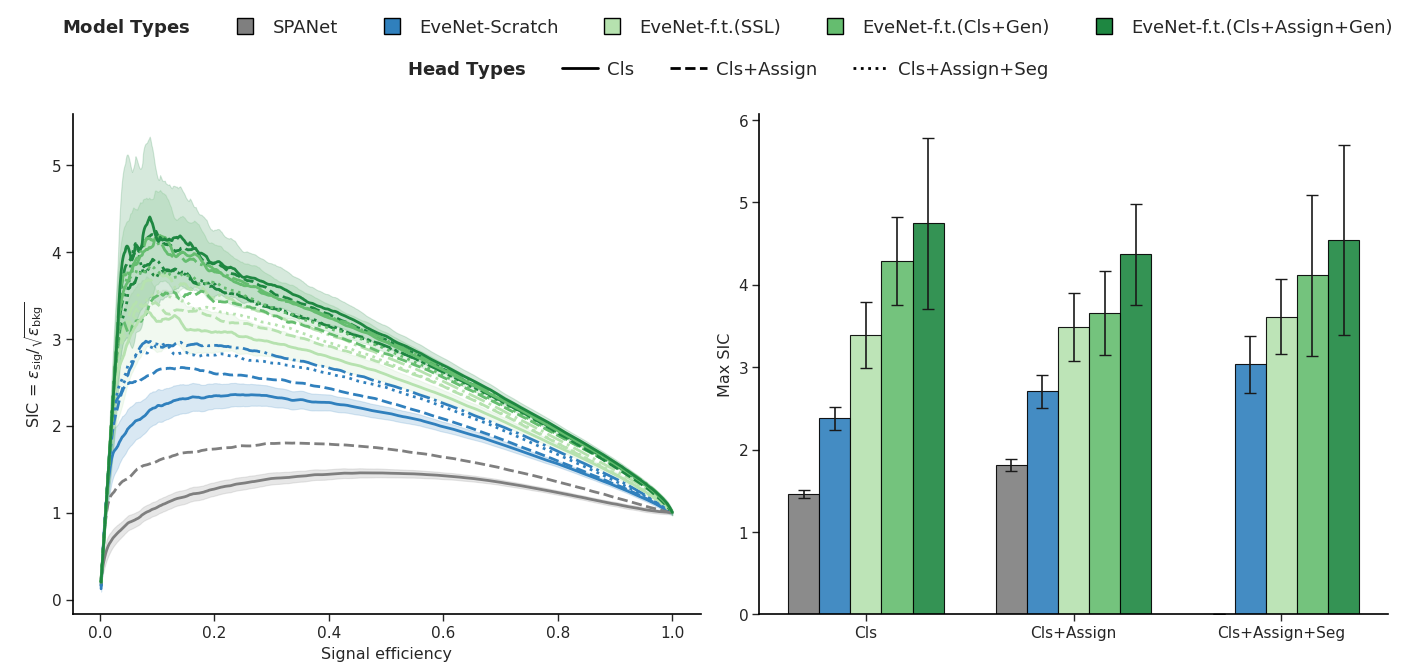

In [18]:

fig = plot_sic_suite_full_dataset(
    metrics_dir=fit_dir,
    mass=mass,
    plotdir="plot/BSM",
    fname="sic_full_dataset.pdf",
    figsize=(14,6)
)